<a href="https://colab.research.google.com/github/mhassouna95/BayesianOptimization-for-ResNet9/blob/master/KMNIST_RestNet9_BayesianOpt_nodrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning rate tuning of a ResNet9 Model using Bayesian Optimization 

## Setup and Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.initializers import GlorotUniform
from keras.optimizers import SGD
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from scipy.optimize import minimize
from scipy.stats import norm
from keras import backend as K




In [8]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 3.3MB/s 


In [9]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

## Data preparation: KMNIST

In [1]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

--2020-08-25 23:07:39--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz’

kmnist-train-imgs.n 100%[===================>]  17.53M  6.94MB/s    in 2.5s    

2020-08-25 23:07:42 (6.94 MB/s) - ‘kmnist-train-imgs.npz’ saved [18384171/18384171]

--2020-08-25 23:07:42--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz’

kmnist-train-labels 100%[===================>]  29.00K  --.-KB/s    in 0.09s   

2020-08-25 23:07:42 (306 KB/s) - ‘kmnist-train-labels.npz’ saved [29700/29

In [10]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# Load the data/content/kmnist-test-imgs.npz
x_train = np.load('./kmnist-train-imgs.npz')['arr_0']
x_test = np.load('./kmnist-test-imgs.npz')['arr_0']
y_train = np.load('./kmnist-train-labels.npz')['arr_0']
y_test = np.load('./kmnist-test-labels.npz')['arr_0']

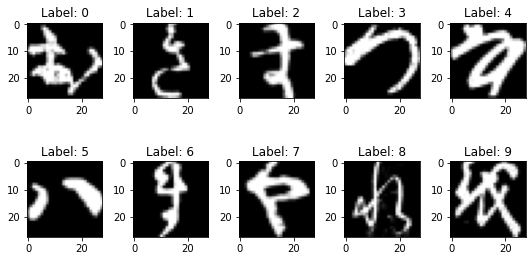

In [11]:
# plot random image of each class
num_row = 2
num_col = 5
fig, axes = plt.subplots(
    num_row, num_col, figsize=(
        1.5 * num_col, 2 * num_row))
for i in range(num_classes):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(x_train[y_train == i][np.random.randint(
        len(x_train[y_train == i]))], cmap='gray')
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.show()

In [12]:
# reshape
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

60000 train samples, 10000 test samples


In [13]:
#encode labels as one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Defining Model : ResNet9 

In [14]:
def ConvBatchNormReLU(input, filters, kernel_size, name, stride, padding="SAME", seed=None):
    """
    Implementation of a convolution followed by a BatchNormalization and a ReLU layer.

    Arguments:
    input -- input tensor.
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path.
    kernel_size -- integer, size of the convolution filter.
    name -- integer, used to name the layers, depending on their position in the network.
    stride -- integer, value for the stride of the conv layer.
    padding -- string/character, padding of the conv layer.
    seed -- integer, random seed for initialization.

    Returns:
    X -- output tensor after Conv -> BatchNorm -> ReLU.
    """
    k = (kernel_size, kernel_size)
    s = (stride, stride)
    X = Conv2D(filters, k, padding=padding, strides=s, name='conv' + str(name), kernel_initializer=GlorotUniform(seed=seed))(input)
    X = BatchNormalization(axis=3, name='bn_conv' + str(name))(X)
    X = Activation('relu', name='relu' + str(name))(X)

    return X

In [15]:
def ResNetBlock(input, filters, kernel_size, name, stride, padding="SAME", pooling=2, seed=None):
    """
    Implementation of a convolution followed by a BatchNormalization and a ReLU layer.

    Arguments:
    input -- input tensor.
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path.
    kernel_size -- integer, size of the convolution filter.
    name -- integer, used to name the layers, depending on their position in the network.
    stride -- integer, value for the stride of the conv layer.
    padding -- string/character, padding of the conv layer.
    pooling -- integer, filter size of the MaxPool layer.
    seed -- integer, random seed for initialization.

    Returns:
    X -- output tensor after a ResNet basic block.
    """

    X = ConvBatchNormReLU(input, filters, kernel_size, str(name) + "a", stride, padding, seed)
    X = MaxPooling2D((pooling, pooling), name="max_pool" + str(name))(X)
    Y = ConvBatchNormReLU(X, filters, kernel_size, str(name) + "b", stride, padding, seed)
    Y = ConvBatchNormReLU(Y, filters, kernel_size, str(name) + "c", stride, padding, seed)
    X = Add(name="add" + str(name))([X, Y])

    return X

In [16]:
def ResNet9(input_shape=(28, 28, 1), classes=10, seed=None):
    """
    Implementation of the ResNet9 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> ResNetBlock -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> ResNetBlock -> MAXPOOL -> Dense.
    Arguments:
    input_shape -- shape of the images of the dataset.
    classes -- integer, number of classes.
    seed -- integer, random seed for initialization.

    Returns:
    model -- a Model() instance in Keras.
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # prep
    X = ConvBatchNormReLU(X_input, filters=64, kernel_size=3, name=0, stride=1, padding="SAME", seed=seed)

    # layer1
    X = ResNetBlock(X, filters=128, kernel_size=3, name=1, stride=1, padding="SAME", pooling=2, seed=seed)

    # layer2
    X = ConvBatchNormReLU(X, filters=256, kernel_size=3, name=2, stride=1, padding="SAME", seed=seed)
    X = MaxPooling2D((2, 2), name="max_pool" + str(2))(X)

    # layer3
    X = ResNetBlock(X, filters=512, kernel_size=3, name=3, stride=1, padding="SAME", pooling=2, seed=seed)

    # classifier
    X = MaxPooling2D((2, 2), name="max_pool_output")(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=GlorotUniform(seed=seed))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet9')

    return model


## Model creation

In [17]:
model = ResNet9(input_shape = (28, 28, 1), classes = 10, seed=None)


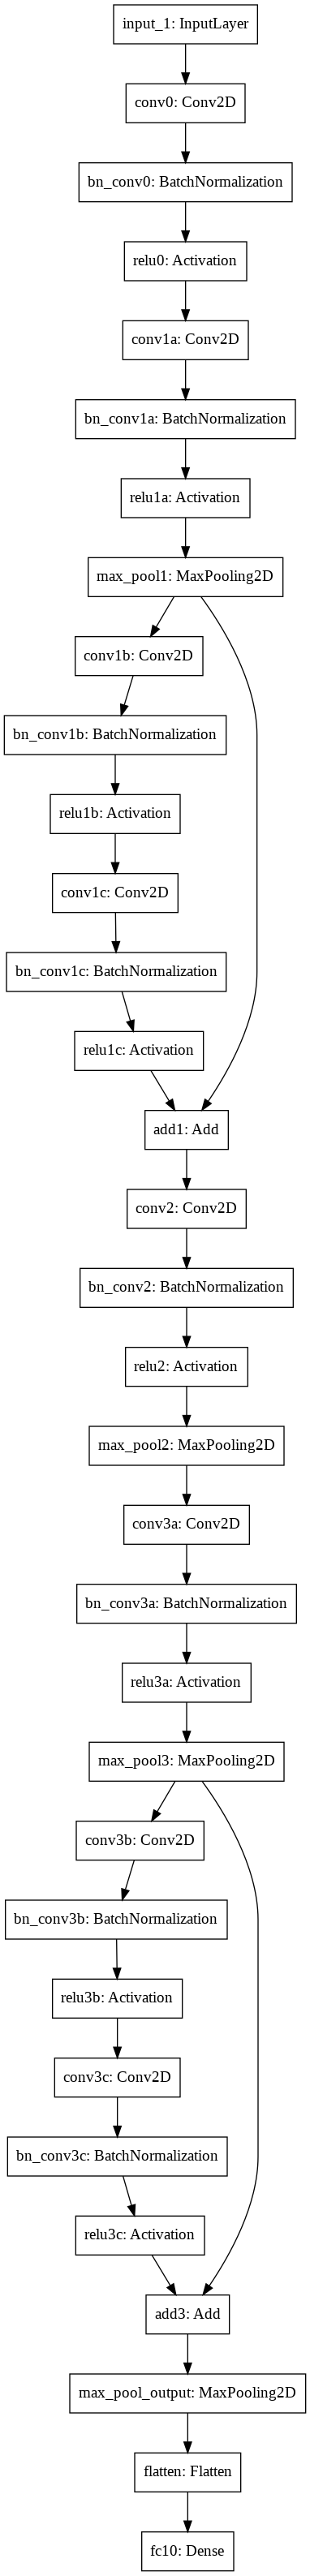

In [18]:
keras.utils.plot_model(model, "resnet9.png")

In [19]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [20]:
"""batch_size = 128
epochs = 1
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

"""

'batch_size = 128\nepochs = 1\nmodel.fit(x_train, y_train,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=1,\n          validation_data=(x_test, y_test))\n\n'

In [21]:
#train_score = model.evaluate(x_train, y_train, verbose=0)
#test_score = model.evaluate(x_test, y_test, verbose=0)
#print('Train loss:', train_score[0])
#print('Train accuracy:', train_score[1])
#print('Test loss:', test_score[0])
#print('Test accuracy:', test_score[1])


## Plotting functions

In [22]:
def plot_approximation(gpr, X, X_sample, Y_sample, X_next=None, show_legend=False):
    """
    Plots the posterior mean and variance of the surrogate model as well as the observed samples.

    Arguments:
    gpr -- Surrogate model, a GaussianProcessRegressor.
    X -- range of X values for the plot.
    X_sample -- values of the hyperparameter samples.
    Y_sample -- values of the blackbox function at X_sample.
    X_next -- boolean, controls the display of the position of the selected hyperparameter.
    show_legend -- boolean, controls the display of the legend.
    Returns:
    model -- a Model() instance in Keras.
    """

    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(),
                     mu.ravel() + 1.96 * std,
                     mu.ravel() - 1.96 * std,
                     alpha=0.1)
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()


def plot_acquisition(X, Y, X_next, show_legend=False):
    """
    Plots the acquisition function.

    Arguments:
    X -- range of X values for the plot.
    Y -- values of the acquisition function at points X.
    X_next -- boolean, controls the display of the position of the selected hyperparameter.
    show_legend -- boolean, controls the display of the legend.
    Returns:
    model -- a Model() instance in Keras.
    """
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()


## Bayesian Optimization

In [23]:
def create_model(learning_rate):
    """
    Creates a ResNet9 Model with SGD optimizer and given learning rate.
    Arguments:
    learning_rate -- learning rate hyperparameter.

    Returns:
    model -- a Model() instance in Keras.
    """
    model = ResNet9(input_shape=(28, 28, 1), classes=10, seed=None)
    sgd = SGD(lr=learning_rate)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [24]:
def blackbox(x, y, learning_rate):
    """
    Calculates blackbox function for bayesian optimization by training a ResNet9 model.

    Arguments:
    learning_rate -- learning rate hyperparameter.
    x -- image data.
    y -- labels.

    Returns:
    validation accuracy of the trained model.
    """
    batch_size = 128
    epochs = 3
    #create ResNet9 model
    model = create_model(learning_rate=learning_rate)
    

    # fit the model
    blackbox = model.fit(x=x,
                        y=y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.15,
                        verbose=0
                        )
    #return the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session
    K.clear_session()
    
    return accuracy

In [25]:
%matplotlib inline

# bounds of the learning rate parameter
bounds = np.array([[1e-5, 1]])
# define initial samples for gaussian process
#X_init = np.array([np.random.uniform(bounds[:, 0], bounds[:, 1]), np.random.uniform(bounds[:, 0], bounds[:, 1])])
X_init = np.array([[1e-3], [2e-1]])

Y_init = np.vstack((blackbox(x_train, y_train, X_init[0][0]), blackbox(x_train, y_train, X_init[1][0])))
Y_init = np.array(Y_init).reshape(-1, 1)


Accuracy: 95.04%


Accuracy: 96.87%



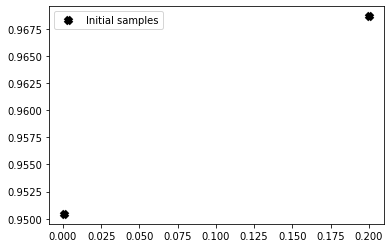

In [26]:
# dense grid of points within bounds
X = np.linspace(bounds[:, 0], bounds[:, 1], 10000).reshape(-1, 1)
plt.plot(X_init, Y_init, 'kx', mew=5, label='Initial samples')
plt.legend()

In [27]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.

    Arguments:
        X -- Points at which EI shall be computed.
        X_sample -- Sample locations.
        Y_sample -- Sample values.
        gpr -- A GaussianProcessRegressor fitted to samples.
        xi -- Exploitation-exploration trade-off parameter.

    Returns:
        Expected improvements at points X.
    '''

    # predict mean and variance for all points
    mu, sigma = gpr.predict(X, return_std=True)

    sigma = sigma.reshape(-1, 1)

    # calculate the best sample (highest accuracy)
    sample_opt = np.max(Y_sample)

    with np.errstate(divide='warn'):
        imp = mu - sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [28]:
def sample_next_hyperparameter(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=50):
    '''
    Proposes the next hyperparameter point by optimizing the acquisition function.

    Args:
        acquisition -- Acquisition function.
        X_sample -- Sample locations.
        Y_sample -- Sample values.
        gpr -- A GaussianProcessRegressor fitted to samples.
        bounds -- Bounds of the hyperparameter.
        n_restarts -- Number of restarts for finding the optimum.

    Returns:
        Location of the acquisition function maximum.
    '''

    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(
            bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x

    return min_x.reshape(-1, 1)


Accuracy: 95.24%


Accuracy: 96.39%


Accuracy: 95.54%


Accuracy: 95.33%


Accuracy: 98.37%


Accuracy: 94.68%


Accuracy: 95.40%


Accuracy: 97.63%


Accuracy: 98.79%


Accuracy: 96.68%



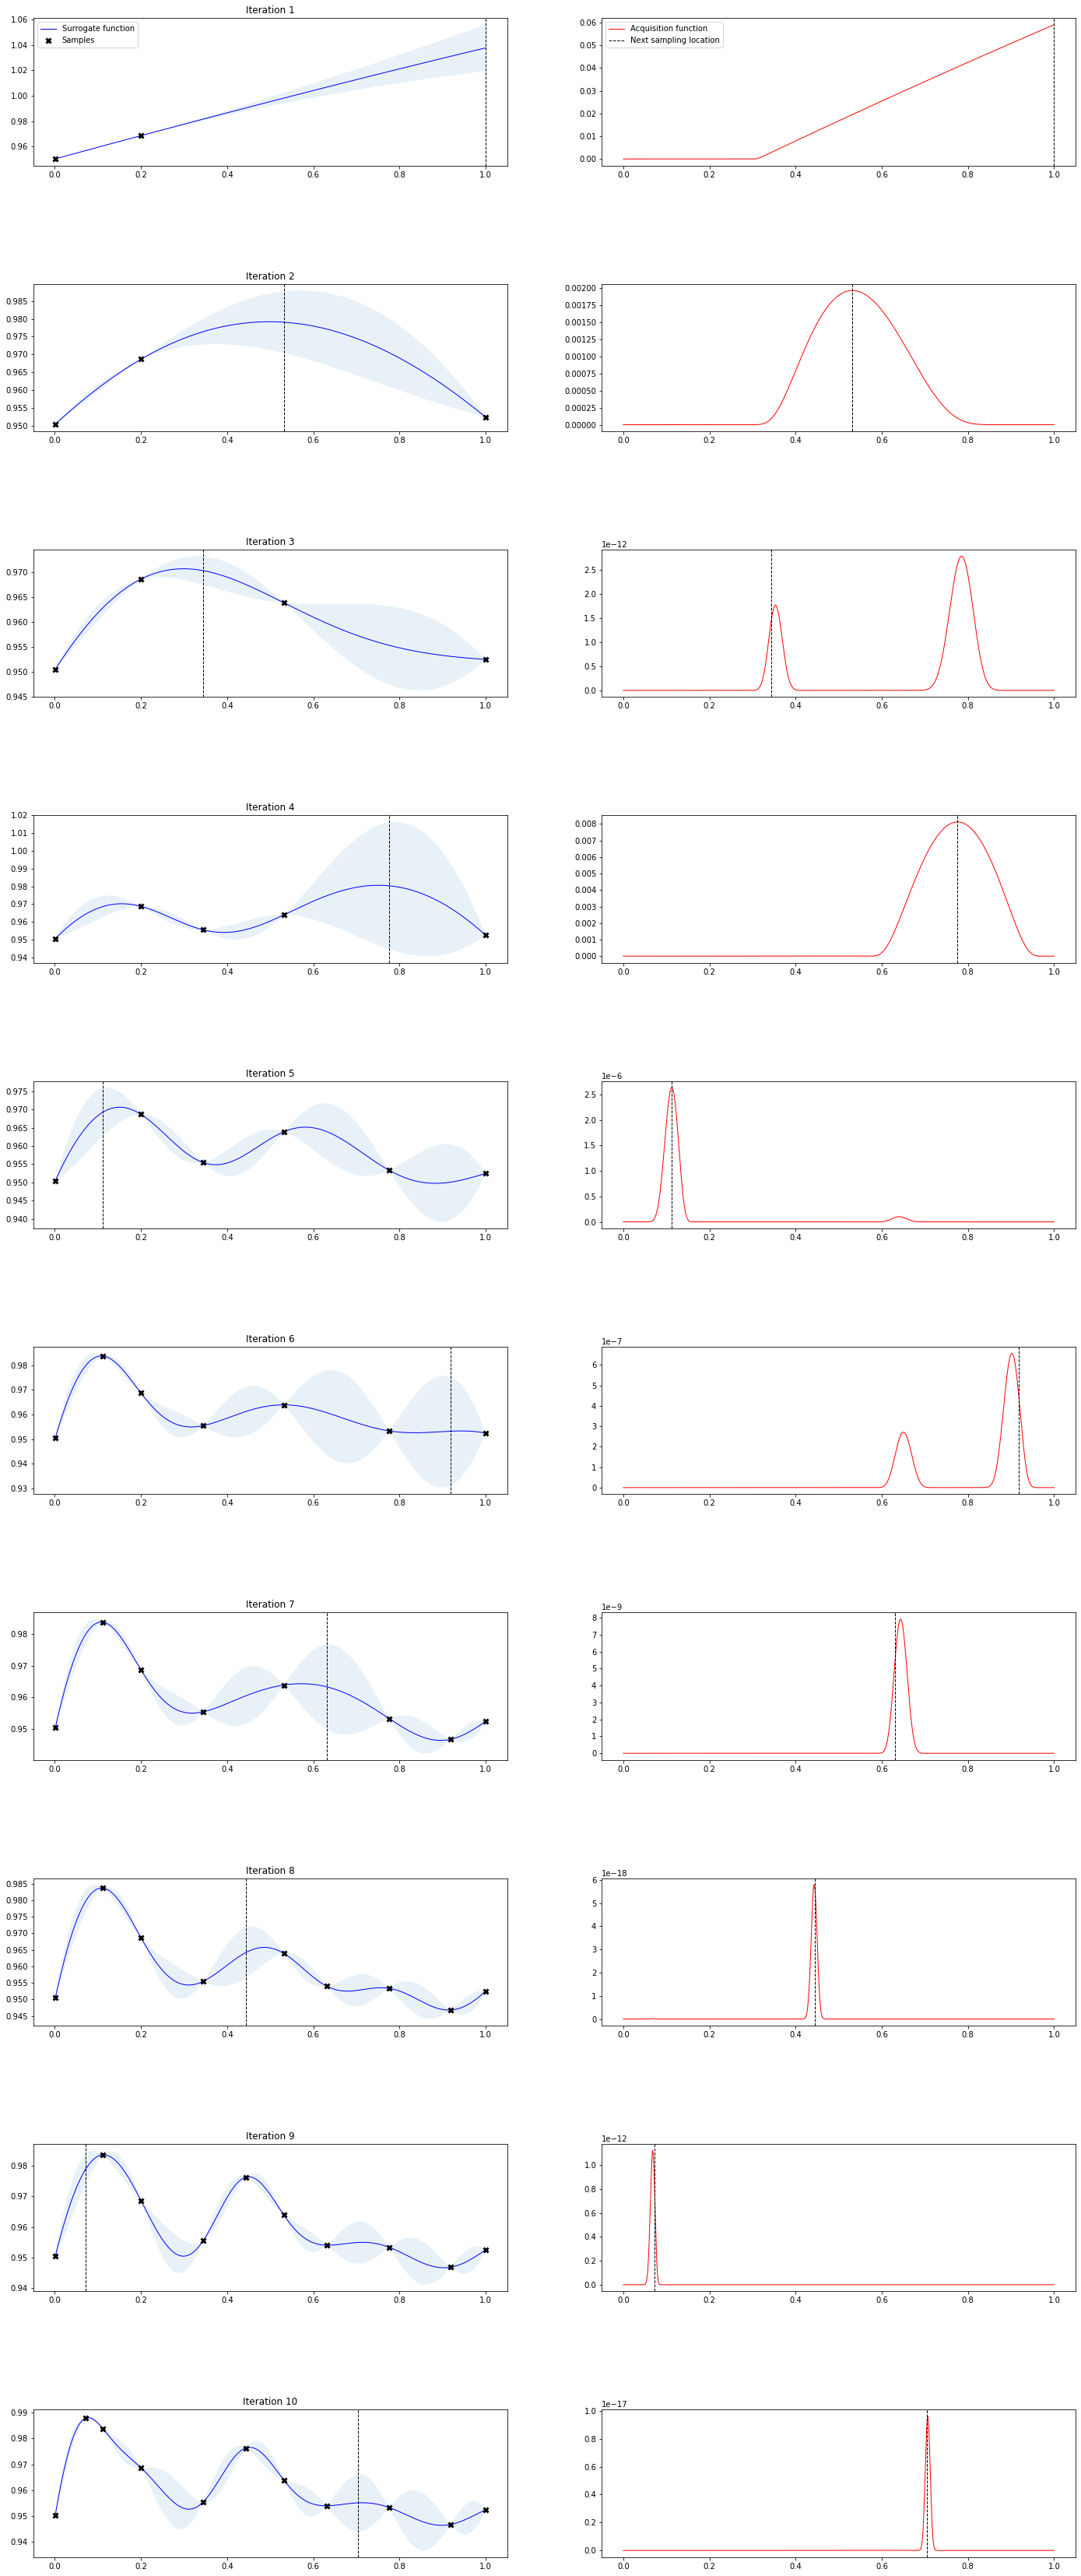

In [29]:
# define gaussian process
gpr =  GaussianProcessRegressor(kernel=ConstantKernel(1.0) * Matern(length_scale=1, nu=2.5))
# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(24, n_iter * 6))
plt.subplots_adjust(hspace=0.8)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function
    # (expected_improvement)
    X_next = sample_next_hyperparameter(expected_improvement, X_sample, Y_sample, gpr, bounds)

    # Obtain next noisy sample from the objective function
    Y_next = blackbox(x_train, y_train, X_next[0][0])

    # Plot samples, surrogate function, noise-free objective and next sampling
    # location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, X_sample, Y_sample, X_next, show_legend=i == 0)
    plt.title('Iteration {}'.format(i + 1))

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i == 0)

    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [30]:
print("Sampled learning rates: ", np.hstack((X_sample, Y_sample)))
best_learning_rate = X_sample[Y_sample.argmax()][0]
print("Best learning rate: ", best_learning_rate)


Sampled learning rates:  [[0.001      0.95044446]
 [0.2        0.96866667]
 [1.         0.95244443]
 [0.53182325 0.96388888]
 [0.34416828 0.95544446]
 [0.77599792 0.95333332]
 [0.11204884 0.98366666]
 [0.91847225 0.94677776]
 [0.63139129 0.954     ]
 [0.44375973 0.97633332]
 [0.07219094 0.98788887]
 [0.70458141 0.9667778 ]]
Best learning rate:  0.07219093629084652


In [31]:
# train a model with the chosen learning rate
model = create_model(best_learning_rate)
batch_size = 128
epochs = 3
model.fit(x_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          )

Epoch 1/3
469/469 [==============================] - 26s 55ms/step - loss: 0.8202 - accuracy: 0.8719
Epoch 2/3
469/469 [==============================] - 25s 53ms/step - loss: 0.0491 - accuracy: 0.9857
Epoch 3/3
469/469 [==============================] - 25s 53ms/step - loss: 0.0201 - accuracy: 0.9948


In [32]:
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.016735883429646492
Train accuracy: 0.9957666397094727
Test loss: 0.18355681002140045
Test accuracy: 0.951200008392334


## Bayesian optimization with skopt

In [33]:
dim_learning_rate = Real(low=1e-5, high=1, prior='uniform', name='learning_rate')
dimensions = [dim_learning_rate]

In [34]:
x0 = [[1e-3],[1e-1]]
y0 = Y_init.ravel()

In [35]:
y0

array([0.95044446, 0.96866667])

In [36]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate):
    batch_size = 128
    epochs = 3
    model = create_model(learning_rate=learning_rate)
    

    blackbox = model.fit(x=x_train,
                        y=y_train,
                        epochs=epochs,
                        verbose=0,
                        batch_size=batch_size,
                        validation_split=0.15,
                        )
    #return the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model
    del model
    
    # Clear the Keras session
    K.clear_session()

    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -accuracy

In [37]:
gpr =  GaussianProcessRegressor(kernel=ConstantKernel(1.0) * Matern(length_scale=1, nu=2.5))
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        base_estimator = gpr,
                        n_calls=10,
                        n_jobs=-1,
                        xi = 0.01,
                        acq_func = "EI",
                        acq_optimizer = "sampling",
                        x0=x0,
                        y0=y0)



Accuracy: 97.62%


Accuracy: 96.74%


Accuracy: 93.62%


Accuracy: 98.63%


Accuracy: 97.93%


Accuracy: 97.33%


Accuracy: 96.62%


Accuracy: 90.80%


Accuracy: 98.68%


Accuracy: 93.00%



In [38]:
scikit_learning_rate = gp_result.x[0]
print("Best skopt learning rate: ", scikit_learning_rate)

Best skopt learning rate:  0.04850524423728586


In [39]:
model = create_model(scikit_learning_rate)
model.fit(x_train,
          y_train,
          epochs=3,
          batch_size=batch_size,
          )

Epoch 1/3
469/469 [==============================] - 25s 53ms/step - loss: 0.6303 - accuracy: 0.9072
Epoch 2/3
469/469 [==============================] - 25s 53ms/step - loss: 0.0422 - accuracy: 0.9880
Epoch 3/3
469/469 [==============================] - 25s 53ms/step - loss: 0.0151 - accuracy: 0.9965


In [40]:
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.007217337377369404
Train accuracy: 0.9992166757583618
Test loss: 0.1277076005935669
Test accuracy: 0.9649999737739563


## References


*   [KMNIST dataset](https://github.com/rois-codh/kmnist)
*   [CNN example](https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py)
*   [ResNet9 arcitecture](https://github.com/JonathanRayner/ResNet9/blob/master/net_diagram.svg
)
*   [ResNet with keras](https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba)
*   [Bayesian optimization with neural networks](https://medium.com/@crawftv/parameter-hyperparameter-tuning-with-bayesian-optimization-7acf42d348e1)
*   [Bayesian optimization from scratch and plotting functions](http://krasserm.github.io/2018/03/21/bayesian-optimization/)
*   [Bayesian optimization with scikit learn](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/)
*   [Bayesian optimization from scratch](https://machinelearningmastery.com/what-is-bayesian-optimization/)
*   [ConvNets ResNet excercise on Coursera](https://www.coursera.org/learn/convolutional-neural-networks)



